# Trabalho



In [47]:
import pandas as pd
import numpy as np
import sympy as sym
import scipy as sp

def read_graph_from_csv(csv_file, directed=True,df=None):
    if df is None:
        # Read CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file, header=None, names=['Source', 'Destination', 'Cost'])

    # Get unique nodes
    nodes = sorted(set(df['Source']) | set(df['Destination']))

    # Create adjacency matrix A and Cost matrix C
    num_nodes = len(nodes)
    A = np.zeros((num_nodes, num_nodes), dtype=int)
    C = np.zeros((num_nodes, num_nodes), dtype=float)

    # Fill adjacency matrix and Cost matrix
    for _, row in df.iterrows():
        Source_index = nodes.index(row['Source'])
        destination_index = nodes.index(row['Destination'])
        A[Source_index, destination_index] = 1
        C[Source_index, destination_index] = row['Cost']
        if not directed:
            # For undirected graph, add edges in both directions
            A[destination_index, Source_index] = 1
            C[destination_index, Source_index] = row['Cost']

    return A, C

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph_from_csv(csv_file, directed=True,df=None):
    if df is None:
        # Read CSV file into a pandas DataFrame
        df = pd.read_csv(csv_file, header=None, names=['Source', 'Destination', 'Cost'])

    # Create a directed or undirected graph
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row['Source'], row['Destination'], weight=row['Cost'])

    # Position nodes using the spring layout algorithm
    pos = nx.spring_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=directed)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Draw node labels
    nx.draw_networkx_labels(G, pos)

    # Show plot
    plt.title('Graph')
    plt.axis('off')
    plt.show()

In [49]:
def generate_random_graph(num_vertices, num_edges_per_vertex, RandomCostFunction, randomCostArgs=(),randomCostKWArgs={}):
    G = nx.Graph()
    # Add vertices
    G.add_nodes_from(range(num_vertices))
    
    # Add edges
    for v in range(num_vertices):
        # Generate random edges for each vertex
        edges = np.random.choice(range(num_vertices), size=num_edges_per_vertex, replace=False)
        for edge in edges:
            # Ensure not to add self-loops
            if edge != v:
                # Generate random Cost for each edge
                Cost = RandomCostFunction(*randomCostArgs,**randomCostKWArgs)  # Adjust range as per your requirements
                G.add_edge(v, edge, weight=Cost)

    # Extract edges and their attributes (Cost)
    edges_data = [(Source, target, data['weight']) for Source, target, data in G.edges(data=True)]
    
    # Create DataFrame from edges data
    df = pd.DataFrame(edges_data, columns=['Source', 'Destination', 'Cost'])

    return df

In [50]:
class Grafo:
    def __init__(self,numeroNos,nosEnlace,custo,custoArgs=(),custoKwargs={}):
        self.enlaces = generate_random_graph(numeroNos,nosEnlace,custo,custoArgs,custoKwargs)
        self.A, self.C = read_graph_from_csv('', directed=True,df=self.enlaces)
        self.fontes, self.destinos = ([],[])
        self.nullSpace = None
        self.mudou = True
        self.nullFlowConservationMatrix = None
        self.contractFlowConservationMatrix = None
        self.flowConservationMatrix = None
        self.contratos = []
        
    def VerGrafo(self):
        plot_graph_from_csv('',directed=False,df=self.enlaces)

    def ImportarGrafo(self,csv_file):
        self.A, self.C = read_graph_from_csv(csv_file, directed=True,df=self.enlaces)
        self.enlaces = pd.read_csv(csv_file, header=None, names=['Source', 'Destination', 'Cost'])
        self.mudou = True
        
    def ExportarGrafo(self,filename):
        self.enlaces.to_csv(filename)

    def AdicionarFonte(self,fonte):
        self.fontes.append(fonte)

    def MostrarGrafo(self):
        plot_graph_from_csv('',directed=False,df=self.enlaces)
        
    def AdicionarDestino(self,destino):
        self.fontes.append(destino)

    def MapearVariaveisLivres(self):
        if not self.mudou:
            self.nullSpace.shape[1]
        self.mudou = False
        
        self.ValidarListaEnlaces()
        # -------- CASO DIRECIONADO ------------------
        # Transformação de enlaces de selfs não direcionados para enlaces de selfs direcionados
        directedEdges = pd.DataFrame(
            np.concatenate(
                [self.enlaces,self.enlaces[['Destination','Source','Cost']]]
                )
            ,columns=['Source','Destination','Cost'])
        #
        # Calculo da matriz de conservação de fluxos
        nosTotais = list(set(self.enlaces['Source']).union(set(self.enlaces['Destination'])))
        nosTotais.sort()
        
        self.flowConservationMatrix = np.stack(
            [(1*(directedEdges['Source']==i))-(1*(directedEdges['Destination']==i)) for i in nosTotais]
        )
        # ----------------------------------------------

        # Caso não direcionado
        #self.flowConservationMatrix = np.stack(
        #    [
        #        (1*(self.enlaces['Source']==i))+1*(self.enlaces['Destination']==i) 
        #         for i in set(self.enlaces['Source'].unique()).union(set(self.enlaces['Destination'].unique()))]
        #)
        
        # Calculo dos índices
        filtroFonte = pd.Series(np.arange(self.flowConservationMatrix.shape[0])).isin(self.fontes)
        filtroDestino = pd.Series(np.arange(self.flowConservationMatrix.shape[0])).isin(self.destinos)
        filtro = ~(np.array(filtroFonte)|np.array(filtroDestino))

        # Separa a matriz de conservação de fluxo em dois: Uma para os nós intermediários e outra
        # para os nós fonte/destino
        self.nullFlowConservationMatrix = self.flowConservationMatrix[filtro,:]
        self.sourceFlowMatrix = self.flowConservationMatrix[filtroFonte,:]
        self.sourceFlowMatrix = np.where(self.sourceFlowMatrix > 0, self.sourceFlowMatrix, 0)
        self.destinationFlowMatrix = self.flowConservationMatrix[filtroFonte,:]
        self.destinationFlowMatrix = np.where(self.destinationFlowMatrix < 0, -self.destinationFlowMatrix,0)
        self.flowConservationMatrix = None
        
        # Calcula-se o espaço nulo da matriz
        self.nullSpace = sp.linalg.null_space(self.nullFlowConservationMatrix)

        # Retorna o número de variáveis livres disponível
        return self.nullSpace.shape[1]
    
    def CalcularFluxoReal(self,fluxoLivre):
        if self.nullSpace is None:
            raise Exception("Deve-se rodar MapearVariaveisLivres antes de calcular o fluxo")
            
        if fluxoLivre.shape[0] != self.nullSpace.shape[1]:
            raise Exception("A variável de fluxo livre não tem a mesma dimensão que o número de variáveis livres")

        fluxoReal = self.nullSpace@fluxoLivre
        fluxoReal = np.sum(fluxoReal.reshape(2,-1),axis=0)
        return fluxoReal
    
    def CustoEnlaces(self):
        return self.enlaces['Cost']

    def FluxoContratos(self):
        return self.contractFlowConservationMatrix 

    def CalcularFluxoContratos(self,xReal):
        xExpandido = np.concatenate([np.where(xReal > 0,xReal,0),np.where(xReal<0,-xReal,0)])
        fluxoContratos = self.contractFlowConservationMatrix@xExpandido
        fluxoReal = np.sum(fluxoContratos.reshape(2,-1),axis=0)
        return fluxoReal 

    def Custo(self,x):
        xReal = self.CalcularFluxoReal(x)
        custoEnlace = 0#np.abs(self.CustoEnlaces().T@xReal)
        custoDivergirDoContrato = np.sum(np.power(self.CalcularFluxoContratos(xReal)-contratos,2))
        custoUltrapassarCapacidade = 1e10*np.sum(xReal>capacidade)
        custoFluxoNegativo = 1e10*np.sum(xReal<-1e-10)
        return  custoEnlace + custoDivergirDoContrato + custoUltrapassarCapacidade + custoFluxoNegativo
    
    def FluxoNulo(self):
        return self.nullFlowConservationMatrix 
        
    def ValidarListaEnlaces(self):
        """
        Não pode existir na lista de enlaces não direcionados entradas (x,y) e (y,x), já que são o mesmo enlace
        """
        for i in self.enlaces['Source'].unique():
            for j in self.enlaces['Destination'].unique():
                if self.enlaces[(self.enlaces['Destination'] == i)&(self.enlaces['Source'])==j].shape[0] > 0:
                    raise Exception("Lista mal definida. Não pode existir na lista de enlaces não direcionados entradas (x,y) e (y,x), já que são o mesmo enlace")

# Mapeamento de espaço


## Função custo
Deve conter: 
* Soma dos custos pelo fluxo passando no enlace
* Soma dos fluxos fora do contrato

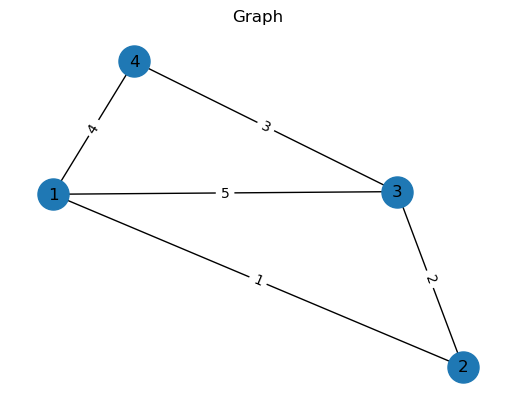

8

In [53]:
# Cria um novo grafo
grafo = Grafo(10,6,np.random.randint,(1,10))

# Importa um novo grafo
grafo.ImportarGrafo('graph.csv')
grafo.MostrarGrafo()

contratos = [
    (1,2,10)
]

# Adiciona fonte e destino para fluxos de dados
for fonte,destino,fluxo in contratos:
    grafo.AdicionarFonte(fonte)
    grafo.AdicionarDestino(destino)

# Define o fluxo de contrato (positivo -> entrando, negativo -> saindo)
fluxoContrato = np.array([[10],[10]])

# Mapeia o número de variáveis livres que podem ser modificadas
Nl = grafo.MapearVariaveisLivres()
Nl

In [54]:
contratos=np.array([[10],[10]])
capacidade = np.array([[5,5,5,5]]).T



## Simmulated Annealing

Testar a função agora com o valor de fluxo

In [57]:
%pdb off
# Parâmetros do simulated annealing
N = 1000000
T0 = 10
epsilon = 10
K= 20

# Definição das variáveis
X = np.zeros((grafo.MapearVariaveisLivres(),1)); 
# O meu valor deve ser -xp?
#a = np.concatenate([grafo.FluxoNulo(),grafo.FluxoContratos()])
#b = np.concatenate([np.zeros((2,1)),np.array([[-10,10]]).T])
#xp = np.linalg.lstsq(a,b)
#XCompleto = -xp[0]
#XCompleto += np.min(XCompleto)
#X = np.linalg.pinv(grafo.nullSpace)@XCompleto


JX = Custo(X,grafo)
fim=0; n=0; k=0; Jmin=Custo(X,grafo); Xmin=X; T=T0;
history_J=np.zeros([int(N*K),1]); history_T=np.zeros([int(N*K),1])

# Main Loop
while not(fim):
    T=T0/np.log2(2+k)
    #T = T0/(k+1)
    count = 0
    countSteps = 0
    for n in range(0,N):
        Xhat=X+epsilon*np.random.normal(0,1,np.shape(X))
        #Xhat=X+epsilon*np.random.standard_cauchy(np.shape(X))
        JXhat=Custo(Xhat,grafo) 
        if JXhat < 1e10:
            count += 1
        if np.random.uniform()<np.exp((JX-JXhat)/T):
            countSteps += 1
            X=Xhat; JX=JXhat
            if JX<Jmin:
                Jmin=JX; Xmin=X;
        history_J[k*N+n]=JX
        history_T[k*N+n]=T
        if np.remainder(n+1,10000)==0:
            print([k,n+1,Jmin,f"{JX:.2f}",f"{JXhat:.2f}",count/N,countSteps/N,(count+1)/(countSteps+1)],end=' '*10+'\r')
    k+=1
    if k==K: fim=1

Automatic pdb calling has been turned OFF


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [42]:
grafo.contractFlowConservationMatrix 

array([[-1,  0,  0,  1,  0,  1,  0,  0, -1,  0],
       [ 0,  0, -1,  0, -1,  0,  0,  1,  0,  1]])